In [ ]:
# test m5C model in yeast rRNA

In [7]:
import argparse
import traceback

import pandas as pd
import numpy as np
from scipy import interpolate

from sklearn import metrics
from sklearn import datasets
from sklearn.model_selection import train_test_split as ts
from sklearn.metrics import roc_curve,auc,roc_auc_score,precision_recall_curve

import torch
import torch.nn as nn
from torch.utils.data import Dataset
from torch.autograd import Variable

from plotnine import *
import warnings

# Ignore all warnings
warnings.filterwarnings("ignore")


torch.cuda.empty_cache()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("device=",device)

black = '#222222'
gray = '#666666'
red = '#FF3333'
green = '#66CC00'
blue = '#3333FF'
purple = '#9933FF'
orange = '#FF8000'
yellow = '#FFFF33'



class Config:

    train_dir="m5C/feature/train/"
    test_dir="ELIGOS_C/feature/test/"
    #train_dir = "data/motif/CTCAC/train/"
    #test_dir = "data/motif/CTCAC/test/"
    batch_size = 500
    learning_rate=0.00001
    
    
kmer_encode_dic={'A': 0, "C": 1, "G": 2, "T": 3}   

class BahdanauAttention(nn.Module):
    """
    Bahdanau Attention mechanism module.

    Args:
        in_features (int): Number of input features.
        hidden_units (int): Number of hidden units.
        num_task (int): Number of tasks.
    """
    def __init__(self,in_features, hidden_units,num_task):
        super(BahdanauAttention,self).__init__()
        self.W1 = nn.Linear(in_features=in_features,out_features=hidden_units)
        self.W2 = nn.Linear(in_features=in_features,out_features=hidden_units)
        self.V = nn.Linear(in_features=hidden_units, out_features=num_task)

    def forward(self, hidden_states, values):
        hidden_with_time_axis = torch.unsqueeze(hidden_states,dim=1)

        score  = self.V(nn.Tanh()(self.W1(values)+self.W2(hidden_with_time_axis)))
        attention_weights = nn.Softmax(dim=1)(score)
        values = torch.transpose(values,1,2)   # transpose to make it suitable for matrix multiplication
        #print(attention_weights.shape,values.shape)
        context_vector = torch.matmul(values,attention_weights)
        context_vector = torch.transpose(context_vector,1,2)
        return context_vector, attention_weights

class TandemMod(nn.Module):
    def __init__(self,num_classes=2,vocab_zie=5, embedding_size=4,seq_len=5):
        super(TandemMod,self).__init__()

        self.seq_len=seq_len
        self.embed = nn.Embedding(vocab_zie, embedding_size)

        self.cnn_1d = nn.Sequential(
            nn.Conv1d(in_channels=1,out_channels=64,kernel_size=7,stride=2,padding=0),
            nn.ReLU(),
            nn.Dropout(p=0.2),
            nn.Conv1d(in_channels=64,out_channels=128,kernel_size=3,stride=1,padding=0),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2,padding=1),
            nn.Dropout(p=0.2),
            nn.Conv1d(in_channels=128,out_channels=128,kernel_size=3,stride=1,padding=1),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2,padding=1),

        )
        self.lstm=nn.LSTM(input_size=128,hidden_size=128,batch_first=True,bidirectional=True)
        self.attention=BahdanauAttention(in_features=256,hidden_units=10,num_task=1)
        self.fc = nn.Sequential(
            nn.Linear(in_features=1536,out_features=1536),
            nn.ReLU(),
            nn.Linear(in_features=1536, out_features=1024),
            nn.ReLU(),
            nn.Linear(in_features=1024, out_features=512),
            nn.ReLU(),
            nn.Linear(in_features=512, out_features=512),
            nn.ReLU(),
            nn.Linear(in_features=512,out_features=2)
        )

        self.lstm_seq=nn.LSTM(input_size=4+5,hidden_size=128,batch_first=True,bidirectional=True)   #embedding_size+feature_num


    def seq_to_digit(self,seq):
        return torch.Tensor([{'A': 0, "C": 1, "G": 2, "T": 3}[i] for i in list(seq)]).long()


    def forward(self,x,kmer,mean,std,intense,dwell,base_quality):
        kmer_embedded=self.embed(kmer)
        mean = torch.reshape(mean, (-1, self.seq_len, 1)).float()
        std = torch.reshape(std, (-1, self.seq_len, 1)).float()
        intense = torch.reshape(intense, (-1, self.seq_len, 1)).float()
        dwell = torch.reshape(dwell, (-1, self.seq_len, 1)).float()
        base_quality = torch.reshape(base_quality, (-1, self.seq_len, 1)).float()
        
        out_seq=torch.cat((kmer_embedded,mean,std,intense,dwell,base_quality),2)


        out_seq,(h_n_seq,c_n_seq)=self.lstm_seq(out_seq)

        x = self.cnn_1d(x)

        batch_size, features, seq_len = x.size()
        x = x.view(batch_size, seq_len, features)  # parepare input for LSTM

        output, (h_n, c_n) = self.lstm(x)

        h_n = h_n.view(batch_size, output.size()[-1])  # pareprae input for Attention
        context_vector, attention_weights = self.attention(h_n, output)  # Attention (batch_size, num_task, unit)


        out=torch.cat((out_seq[:,0,:],out_seq[:,1,:],out_seq[:,2,:],out_seq[:,3,:],out_seq[:,4,:],context_vector[:,0,:]),1)
        #out=context_vector[:,0,:]
        out.view(out.size()[0],1,out.size()[1])
        x=self.fc(out)
        #x.view(x.size()[0], 1, x.size()[1])
        return x


class NN(TandemMod):
    def __init__(self):
        """
        Initialize the NN class.
        Inherits from the TandemMod class.
        """
        super(NN, self).__init__()





class MyDataset(Dataset):
    """
    Custom dataset class.

    Args:
        x (list or numpy array): Input data.
        y (list or numpy array): Target data.

    """
    def __init__(self,x,y):
        self.x=x
        self.y=y

    def __getitem__(self, index):
        return self.x[index],self.y[index]

    def __len__(self):
        return len(self.x)


def make_weights_for_balanced_classes(images, nclasses):
    """
    Computes weights for balancing classes in a dataset.

    Args:
        images (list): List of images.
        nclasses (int): Number of classes.

    Returns:
        list: List of weights.

    """
    count = [0] * nclasses
    for item in images:
        count[item[1]] += 1
    weight_per_class = [0.] * nclasses
    N = float(sum(count))
    for i in range(nclasses):
        weight_per_class[i] = N/float(count[i])
    weight = [0] * len(images)
    for idx, val in enumerate(images):
        weight[idx] = weight_per_class[val[1]]
    return weight


from torch.utils.data import WeightedRandomSampler
class CustomWeightedRandomSampler(WeightedRandomSampler):
    """
    Custom implementation of WeightedRandomSampler.
    WeightedRandomSampler except allows for more than 2^24 samples to be sampled
    Args:
        *args: Variable length argument list.
        **kwargs: Arbitrary keyword arguments.

    """
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)

    def __iter__(self):
        rand_tensor = np.random.choice(range(0, len(self.weights)),
                                       size=self.num_samples,
                                       p=self.weights.numpy() / torch.sum(self.weights).numpy(),
                                       replace=self.replacement)
        rand_tensor = torch.from_numpy(rand_tensor)
        return iter(rand_tensor.tolist())

print("loading data...")

model = TandemMod(num_classes=2,vocab_zie=5, embedding_size=4,seq_len=5).to(device)
optimizer = torch.optim.Adam(model.parameters(),lr = 0.001)

loss_func = torch.nn.CrossEntropyLoss()#.to(device)
#predict_result=open("rice/results/WT_precit_results.tsv","w")

def predict(model,dataset,cut_off_threshold):
    """
    Predicts the output of the model on the given dataset.

    Parameters:
        model (nn.Module): The trained model to use for prediction.
        dataset (torch.utils.data.Dataset): The dataset to predict on.

    Returns:
        fpr (array): False positive rates.
        tpr (array): True positive rates.
        precision (array): Precision values.
        recall (array): Recall values.
        roc_auc (float): Area under the ROC curve.
        pr_auc (float): Area under the precision-recall curve.
    """

    dataloader=torch.utils.data.DataLoader(dataset=dataset, 
                                           batch_size=20000, 
                                           shuffle=True,
                                           num_workers=36,
                                           pin_memory=True)

    try:

        test_acc = 0.
        y_test = []
        y_pred = []
        label_dict={0:"m5C",1:"C"}

        for i,(batch_x, batch_y) in enumerate(dataloader):

            signal, kmer, mean, std, intense, dwell,base_quality = batch_x
            signal= Variable(signal.to(device)).to(torch.float32)

            kmer = Variable(kmer.to(device)).to(torch.long)
            mean = Variable(mean.to(device)).to(torch.float32)
            std = Variable(std.to(device)).to(torch.float32)
            intense = Variable(intense.to(device)).to(torch.float32)
            dwell = Variable(dwell.to(device)).to(torch.float32)
            base_quality = Variable(base_quality.to(device)).to(torch.float32)
            batch_size, features = signal.size()
            signal = signal.view(batch_size, 1, features)

            out = model(signal, kmer, mean, std, intense, dwell,base_quality )
            batch_size, out_channels = out.size()

            out = out.view(batch_size, out_channels)
            pred = torch.max(out, 1)[1].numpy()

            out=torch.softmax(out,dim=1)
            probabilities=out.detach().numpy()[:,1]
            batch_y=batch_y.detach().numpy()
            #print(probabilities)
            
            
            selected_batch_y=[]
            selected_probabilities=[]
            for j in range(len(batch_y)):
                if probabilities[j]<cut_off_threshold[0] or probabilities[j]>cut_off_threshold[1]:
                    selected_batch_y.append(batch_y[j])
                    selected_probabilities.append(probabilities[j])
            
            print("Probability cutoff:",cut_off_threshold[0],cut_off_threshold[1],"\tPreserved sites:",len(selected_batch_y))
            fpr,tpr,thersholds=roc_curve(selected_batch_y,selected_probabilities)
            precision,recall,thersholds=precision_recall_curve(selected_batch_y,selected_probabilities)
            
            roc_auc=auc(fpr,tpr)
            pr_auc=auc(recall,precision)
            
            return fpr,tpr,precision,recall,roc_auc,pr_auc,len(selected_batch_y)/len(batch_y),probabilities,batch_y
            
    except Exception as e:
        print(e)
        traceback.print_exc()
        
if __name__ == "__main__":
    parser = argparse.ArgumentParser(description='Extract feature from signal.')
    parser.add_argument('-feature', default='BaseCalled_template',help='Basecall subgroup Nanoraw resquiggle into. Default is BaseCalled_template')
    args = parser.parse_args()
  
    
   

/home/wuyou/.conda/envs/TandemMod/lib/python3.7/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


device= cpu
loading data...


In [ ]:
#yeast rRNA DRS basecalling
guppy_basecaller -i /home/wuyou/Projects/paper/yeast/workspace \
    -s /home/wuyou/Projects/paper/yeast/workspace_guppy --num_callers 9 \
    --recursive --fast5_out --config rna_r9.4.1_70bps_hac.cfg
 

#
multi_to_single_fast5 -i /home/wuyou/Projects/paper/yeast/workspace_guppy \
    -s /home/wuyou/Projects/paper/yeast/workspace_guppy_single -t 40 --recursive

#resquiggle
tombo resquiggle --overwrite --basecall-group Basecall_1D_001 /home/wuyou/Projects/paper/yeast/workspace_guppy_single \
    /home/wuyou/Projects/paper/yeast/reference.fasta --processes 40 --fit-global-scale --include-event-stdev


cat /home/wuyou/Projects/paper/yeast/workspace_guppy/pass/*.fastq >/home/wuyou/Projects/paper/yeast.fastq
minimap2 -ax map-ont /home/wuyou/Projects/paper/yeast/reference.fasta \
    /home/wuyou/Projects/paper/yeast.fastq >/home/wuyou/Projects/paper/yeast.sam

python /home/wuyou/Projects/paper/TandemMod/scripts/extract_signal_from_fast5.py -p 40 \
    --fast5 /home/wuyou/Projects/paper/yeast/workspace_guppy_single \
    --reference /home/wuyou/Projects/paper/yeast/reference.fasta \
    --sam /home/wuyou/Projects/paper/yeast.sam \
    --output /home/wuyou/Projects/paper/yeast.signal.tsv --clip 10

python /home/wuyou/Projects/paper/TandemMod/scripts/extract_feature_from_signal.py  \
    --signal_file /home/wuyou/Projects/paper/yeast.signal.tsv --clip 10 \
    --output /home/wuyou/Projects/paper/yeast_A.feature.tsv --motif NNANN

python /home/wuyou/Projects/paper/TandemMod/scripts/extract_feature_from_signal.py  \
    --signal_file /home/wuyou/Projects/paper/yeast.signal.tsv --clip 10 \
    --output /home/wuyou/Projects/paper/yeast_C.feature.tsv --motif NNCNN

In [ ]:
1

In [2]:
#get read quality
import numpy as np
read_id_dict={}
read_qualities=[]
length_dict={}
sam_file="/home/wuyou/Projects/paper/yeast.sam"
with open(sam_file) as f:
    for line in f:
        if line[0]=="@":
            continue
            
        read_id=line.split("\t")[0]
        flag=line.split("\t")[1]
        quality_string_list=list(line.split("\t")[10])
        #print(quality_string_list)
        quality_int_list = [ord(char) - 33 for char in quality_string_list]
        
        read_quality=np.mean(quality_int_list)
        if read_quality>20 and len(quality_int_list)>600:
            read_qualities.append(read_quality)
            read_id_dict[read_id]=1
print(len(read_id_dict))

18964


In [4]:
#all sites
input_feature="/home/wuyou/Projects/paper/yeast_C.feature.tsv"
output_feature="/home/wuyou/Projects/paper/yeast/test"
out=open(output_feature,"w")
with open(input_feature) as f:
    for line in f:
        read_id=line.split("\t")[0]
        contig=line.split("\t")[1]
        site=int(line.split("\t")[2])
        motif=line.split("\t")[3]
        #if contig=="25s" and site>=2600 and site<=2800:
        #if contig=="25s" and site>=0:
        if contig=="25s":
            
            #print(motif)
            if read_id_dict.get(read_id,0):
                out.writelines(line)
out.close()  

Probability cutoff: 0.5 0.5 	Preserved sites: 14789
       Probabilities  label
0           0.010399      0
1           0.977849      0
2           0.272443      0
3           0.001791      0
4           0.019483      0
...              ...    ...
14784       0.000071      0
14785       0.533391      0
14786       0.000242      0
14787       0.009059      0
14788       0.877410      0

[14789 rows x 2 columns]


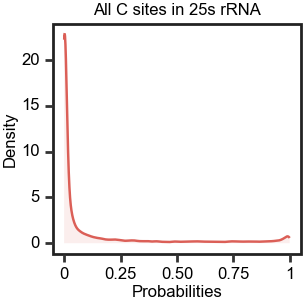

In [6]:
#
modified_site= [645, 649, 650, 663, 805, 807, 817, 867, 876, 898, 908, 1133, 1142, 1437, 1449, 1450, 1888, 2142, 2197, 2220, 2256, 2278, 2280, 2281, 2288, 2337, 2347, 2395, 2417, 2421, 2619, 2634, 2640, 2724, 2729, 2791, 2793, 2870, 2948, 2959,
               750,772, 953, 1231,1566,1602,1755,
              801,711, 947, 997,1500,1632,1703,
               1780,1951,2010,2240,2455,2669,2811]



x_test_median_mad,y_test_median_mad,site_list=[],[],[]
#f=open("/home/wuyou/Projects/paper/yeast_C.feature.tsv")
f=open("/home/wuyou/Projects/paper/yeast/test")
for i,line in enumerate(f):
    if i>3e4:
        break
    line=line.rstrip()
    items=line.split("\t")
    read_id=line.split("\t")[0]
    site=int(line.split("\t")[2])
    if site in modified_site:
        #pass
        continue
        #pass
    if not read_id_dict.get(read_id,0):
        continue

    signals="|".join(items[9:14]).split("|")
    signal=np.array([float(signal) for signal in signals])
    #signal=(signal-np.mean(signal))/np.std(signal)
    kmer = items[3]
    kmer=np.array([kmer_encode_dic[base] for base in kmer])
    mean = np.array([float(item) for item in items[4].split("|")])
    std = np.array([float(item) for item in items[5].split("|")])
    intense = np.array([float(item) for item in items[6].split("|")])
    dwell = np.array([float(item) for item in items[7].split("|")])/200
    base_quality = np.array([float(item) for item in items[8].split("|")])/40
    x=[signal, kmer, mean, std, intense, dwell,base_quality]
    x_test_median_mad.append(x)
    y_test_median_mad.append(0)
    site_list.append(site)
f.close()

dataset=MyDataset(x_test_median_mad,y_test_median_mad)


#model= torch.load('/home/wuyou/Projects/paper/model/m6A_Os_AD_median_mad_length_1000.pkl')
model = torch.load("/home/wuyou/Projects/paper/model/m5C_median_mad.pkl")

fpr,tpr,precision,recall,roc_auc_MMAD,pr_auc_MMAD,preserved_ratio,probabilities,labels=predict(model,dataset,[0.5,0.5])

data=pd.DataFrame(dict(Probabilities=probabilities,label=labels)) 

data_C=data[data["label"]==0]
print(data)
#data.to_csv("data/density_of_reads_probablilities_m5C_on_ELIGOS.csv")
p1 = (ggplot()
        #+geom_bar(data,aes(x="Probabilities",y = "Proportion"),stat="identity",width=0.6)
        +geom_density(data_C,aes(x="Probabilities",fill="black",color="black"),alpha=0.1,show_legend=False)
        +theme(panel_background=element_rect(fill=gray, alpha=0),
            panel_grid_major=element_line(size=0.3, alpha=0,color=black),
            panel_grid_minor=element_line(size=0.3, alpha=0,color=black),
            panel_border=element_rect(color=black, size=1),
            axis_text=element_text(size=6,family="Arial",color="black"),
            axis_title_x=element_text(size=6,family="Arial",color="black"),
            axis_title_y=element_text(size=6,family="Arial",color="black"),
            plot_title=element_text(margin={'b': 1, 'r': 0, 'units': 'pt'},size=6,family="Arial",color="black",hjust=0.5),
            #axis_text_x=element_text(rotation=45, hjust=0.5),
            figure_size=[1.52,1.53],
            #legend_title = element_text(size=6), #change legend title font size
            #legend_text = element_text(size=6),
            #legend_background=element_rect(size=0.5,alpha=0),
            legend_position=(0.60,0.4),
            #legend_key_size=4   #change legend text font size
              ) 
       +xlim([0,1])
        +labs(x = "Probabilities", y ="Density")
        #guides(color = guide_legend(title = "Probability cutoff"))
      +ggtitle("All C sites in 25s rRNA")

)
print(p1)
p1.save("figure/supplemental_figure_6c_yeast_25s_rRNA_C_probability_all_sites.pdf")


In [8]:
#site 1141
input_feature="/home/wuyou/Projects/paper/yeast_C.feature.tsv"
output_feature="/home/wuyou/Projects/paper/yeast/test"
out=open(output_feature,"w")
with open(input_feature) as f:
    for line in f:
        read_id=line.split("\t")[0]
        contig=line.split("\t")[1]
        site=int(line.split("\t")[2])
        motif=line.split("\t")[3]
        #if contig=="25s" and site>=2600 and site<=2800:
        #if contig=="25s" and site>=0:
        if contig=="25s" and site==1141:
            
            #print(motif)
            if read_id_dict.get(read_id,0):
                out.writelines(line)
out.close()  

Probability cutoff: 0.5 0.5 	Preserved sites: 31
    Probabilities  label
0    1.083159e-08      0
1    2.800357e-06      0
2    3.306734e-07      0
3    1.257160e-05      0
4    1.088863e-06      0
5    1.401428e-08      0
6    1.553658e-06      0
7    2.640882e-05      0
8    2.299326e-05      0
9    4.883829e-06      0
10   1.752611e-06      0
11   5.070535e-03      0
12   5.653343e-10      0
13   8.987054e-06      0
14   2.223246e-04      0
15   4.542150e-03      0
16   2.898429e-06      0
17   2.333239e-05      0
18   1.285257e-03      0
19   2.723468e-05      0
20   1.318596e-06      0
21   9.183718e-06      0
22   2.557215e-04      0
23   7.097361e-07      0
24   1.113400e-07      0
25   6.463783e-06      0
26   2.290640e-04      0
27   9.469206e-05      0
28   1.607443e-03      0
29   2.390904e-07      0
30   4.698935e-09      0


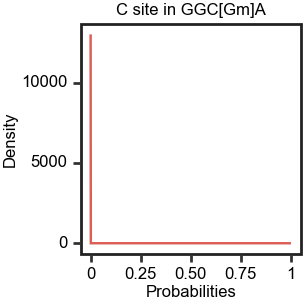

In [9]:
#
modified_site= [645, 649, 650, 663, 805, 807, 817, 867, 876, 898, 908, 1133, 1142, 1437, 1449, 1450, 1888, 2142, 2197, 2220, 2256, 2278, 2280, 2281, 2288, 2337, 2347, 2395, 2417, 2421, 2619, 2634, 2640, 2724, 2729, 2791, 2793, 2870, 2948, 2959,
               750,772, 953, 1231,1566,1602,1755,
              801,711, 947, 997,1500,1632,1703,
               1780,1951,2010,2240,2455,2669,2811]



x_test_median_mad,y_test_median_mad,site_list=[],[],[]
#f=open("/home/wuyou/Projects/paper/yeast_C.feature.tsv")
f=open("/home/wuyou/Projects/paper/yeast/test")
for i,line in enumerate(f):
    if i>3e4:
        break
    line=line.rstrip()
    items=line.split("\t")
    read_id=line.split("\t")[0]
    site=int(line.split("\t")[2])
    if site in modified_site:
        #pass
        continue
        #pass
    if not read_id_dict.get(read_id,0):
        continue

    signals="|".join(items[9:14]).split("|")
    signal=np.array([float(signal) for signal in signals])
    #signal=(signal-np.mean(signal))/np.std(signal)
    kmer = items[3]
    kmer=np.array([kmer_encode_dic[base] for base in kmer])
    mean = np.array([float(item) for item in items[4].split("|")])
    std = np.array([float(item) for item in items[5].split("|")])
    intense = np.array([float(item) for item in items[6].split("|")])
    dwell = np.array([float(item) for item in items[7].split("|")])/200
    base_quality = np.array([float(item) for item in items[8].split("|")])/40
    x=[signal, kmer, mean, std, intense, dwell,base_quality]
    x_test_median_mad.append(x)
    y_test_median_mad.append(0)
    site_list.append(site)
f.close()

dataset=MyDataset(x_test_median_mad,y_test_median_mad)


#model= torch.load('/home/wuyou/Projects/paper/model/m6A_Os_AD_median_mad_length_1000.pkl')
model = torch.load("/home/wuyou/Projects/paper/model/m5C_median_mad.pkl")

fpr,tpr,precision,recall,roc_auc_MMAD,pr_auc_MMAD,preserved_ratio,probabilities,labels=predict(model,dataset,[0.5,0.5])

data=pd.DataFrame(dict(Probabilities=probabilities,label=labels)) 

data_C=data[data["label"]==0]
print(data)
#data.to_csv("data/density_of_reads_probablilities_m5C_on_ELIGOS.csv")
p1 = (ggplot()
        #+geom_bar(data,aes(x="Probabilities",y = "Proportion"),stat="identity",width=0.6)
        +geom_density(data_C,aes(x="Probabilities",fill="black",color="black"),alpha=0.1,show_legend=False)
        +theme(panel_background=element_rect(fill=gray, alpha=0),
            panel_grid_major=element_line(size=0.3, alpha=0,color=black),
            panel_grid_minor=element_line(size=0.3, alpha=0,color=black),
            panel_border=element_rect(color=black, size=1),
            axis_text=element_text(size=6,family="Arial",color="black"),
            axis_title_x=element_text(size=6,family="Arial",color="black"),
            axis_title_y=element_text(size=6,family="Arial",color="black"),
            plot_title=element_text(margin={'b': 1, 'r': 0, 'units': 'pt'},size=6,family="Arial",color="black",hjust=0.5),
            #axis_text_x=element_text(rotation=45, hjust=0.5),
            figure_size=[1.52,1.53],
            #legend_title = element_text(size=6), #change legend title font size
            #legend_text = element_text(size=6),
            #legend_background=element_rect(size=0.5,alpha=0),
            legend_position=(0.60,0.4),
            #legend_key_size=4   #change legend text font size
              ) 
       +xlim([0,1])
        +labs(x = "Probabilities", y ="Density")
        #guides(color = guide_legend(title = "Probability cutoff"))
      +ggtitle("C site in GGC[Gm]A")

)
print(p1)
p1.save("figure/supplemental_figure_6d_yeast_25s_rRNA_C_probability_site1141_GGCGA.pdf")


In [10]:
#site 873
input_feature="/home/wuyou/Projects/paper/yeast_C.feature.tsv"
output_feature="/home/wuyou/Projects/paper/yeast/test"
out=open(output_feature,"w")
with open(input_feature) as f:
    for line in f:
        read_id=line.split("\t")[0]
        contig=line.split("\t")[1]
        site=int(line.split("\t")[2])
        motif=line.split("\t")[3]
        #if contig=="25s" and site>=2600 and site<=2800:
        #if contig=="25s" and site>=0:
        if contig=="25s" and site==873:
            
            #print(motif)
            if read_id_dict.get(read_id,0):
                out.writelines(line)
out.close()  

Probability cutoff: 0.5 0.5 	Preserved sites: 24
    Probabilities  label
0        0.000772      0
1        0.060148      0
2        0.003049      0
3        0.001879      0
4        0.003143      0
5        0.000809      0
6        0.000828      0
7        0.008961      0
8        0.006738      0
9        0.118393      0
10       0.000183      0
11       0.154206      0
12       0.001275      0
13       0.632543      0
14       0.616490      0
15       0.001037      0
16       0.385175      0
17       0.012905      0
18       0.161037      0
19       0.007733      0
20       0.030426      0
21       0.009658      0
22       0.003266      0
23       0.060873      0


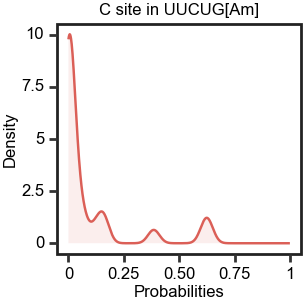

In [11]:
#
modified_site= [645, 649, 650, 663, 805, 807, 817, 867, 876, 898, 908, 1133, 1142, 1437, 1449, 1450, 1888, 2142, 2197, 2220, 2256, 2278, 2280, 2281, 2288, 2337, 2347, 2395, 2417, 2421, 2619, 2634, 2640, 2724, 2729, 2791, 2793, 2870, 2948, 2959,
               750,772, 953, 1231,1566,1602,1755,
              801,711, 947, 997,1500,1632,1703,
               1780,1951,2010,2240,2455,2669,2811]



x_test_median_mad,y_test_median_mad,site_list=[],[],[]
#f=open("/home/wuyou/Projects/paper/yeast_C.feature.tsv")
f=open("/home/wuyou/Projects/paper/yeast/test")
for i,line in enumerate(f):
    if i>3e4:
        break
    line=line.rstrip()
    items=line.split("\t")
    read_id=line.split("\t")[0]
    site=int(line.split("\t")[2])
    if site in modified_site:
        #pass
        continue
        #pass
    if not read_id_dict.get(read_id,0):
        continue

    signals="|".join(items[9:14]).split("|")
    signal=np.array([float(signal) for signal in signals])
    #signal=(signal-np.mean(signal))/np.std(signal)
    kmer = items[3]
    kmer=np.array([kmer_encode_dic[base] for base in kmer])
    mean = np.array([float(item) for item in items[4].split("|")])
    std = np.array([float(item) for item in items[5].split("|")])
    intense = np.array([float(item) for item in items[6].split("|")])
    dwell = np.array([float(item) for item in items[7].split("|")])/200
    base_quality = np.array([float(item) for item in items[8].split("|")])/40
    x=[signal, kmer, mean, std, intense, dwell,base_quality]
    x_test_median_mad.append(x)
    y_test_median_mad.append(0)
    site_list.append(site)
f.close()

dataset=MyDataset(x_test_median_mad,y_test_median_mad)


#model= torch.load('/home/wuyou/Projects/paper/model/m6A_Os_AD_median_mad_length_1000.pkl')
model = torch.load("/home/wuyou/Projects/paper/model/m5C_median_mad.pkl")

fpr,tpr,precision,recall,roc_auc_MMAD,pr_auc_MMAD,preserved_ratio,probabilities,labels=predict(model,dataset,[0.5,0.5])

data=pd.DataFrame(dict(Probabilities=probabilities,label=labels)) 

data_C=data[data["label"]==0]
print(data)
#data.to_csv("data/density_of_reads_probablilities_m5C_on_ELIGOS.csv")
p1 = (ggplot()
        #+geom_bar(data,aes(x="Probabilities",y = "Proportion"),stat="identity",width=0.6)
        +geom_density(data_C,aes(x="Probabilities",fill="black",color="black"),alpha=0.1,show_legend=False)
        +theme(panel_background=element_rect(fill=gray, alpha=0),
            panel_grid_major=element_line(size=0.3, alpha=0,color=black),
            panel_grid_minor=element_line(size=0.3, alpha=0,color=black),
            panel_border=element_rect(color=black, size=1),
            axis_text=element_text(size=6,family="Arial",color="black"),
            axis_title_x=element_text(size=6,family="Arial",color="black"),
            axis_title_y=element_text(size=6,family="Arial",color="black"),
            plot_title=element_text(margin={'b': 1, 'r': 0, 'units': 'pt'},size=6,family="Arial",color="black",hjust=0.5),
            #axis_text_x=element_text(rotation=45, hjust=0.5),
            figure_size=[1.52,1.53],
            #legend_title = element_text(size=6), #change legend title font size
            #legend_text = element_text(size=6),
            #legend_background=element_rect(size=0.5,alpha=0),
            legend_position=(0.60,0.4),
            #legend_key_size=4   #change legend text font size
              ) 
       +xlim([0,1])
        +labs(x = "Probabilities", y ="Density")
        #guides(color = guide_legend(title = "Probability cutoff"))
      +ggtitle("C site in UUCUG[Am]")

)
print(p1)
p1.save("figure/supplemental_figure_6e_yeast_25s_rRNA_C_probability_site873_UUCUG.pdf")


In [3]:
#site 2257
input_feature="/home/wuyou/Projects/paper/yeast_C.feature.tsv"
output_feature="/home/wuyou/Projects/paper/yeast/test"
out=open(output_feature,"w")
with open(input_feature) as f:
    for line in f:
        read_id=line.split("\t")[0]
        contig=line.split("\t")[1]
        site=int(line.split("\t")[2])
        motif=line.split("\t")[3]
        #if contig=="25s" and site>=2600 and site<=2800:
        #if contig=="25s" and site>=0:
        if contig=="25s" and site==2257:
            
            #print(motif)
            if read_id_dict.get(read_id,0):
                out.writelines(line)
out.close()  

Probability cutoff: 0.5 0.5 	Preserved sites: 14789
       Probabilities  label
0           0.001464      0
1           0.737300      0
2           0.848020      0
3           0.000059      0
4           0.001443      0
...              ...    ...
14784       0.469291      0
14785       0.000034      0
14786       0.002110      0
14787       0.000613      0
14788       0.000131      0

[14789 rows x 2 columns]


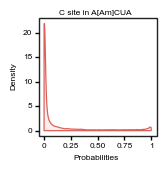

In [8]:
#
modified_site= [645, 649, 650, 663, 805, 807, 817, 867, 876, 898, 908, 1133, 1142, 1437, 1449, 1450, 1888, 2142, 2197, 2220, 2256, 2278, 2280, 2281, 2288, 2337, 2347, 2395, 2417, 2421, 2619, 2634, 2640, 2724, 2729, 2791, 2793, 2870, 2948, 2959,
               750,772, 953, 1231,1566,1602,1755,
              801,711, 947, 997,1500,1632,1703,
               1780,1951,2010,2240,2455,2669,2811]



x_test_median_mad,y_test_median_mad,site_list=[],[],[]
#f=open("/home/wuyou/Projects/paper/yeast_C.feature.tsv")
f=open("/home/wuyou/Projects/paper/yeast/test")
for i,line in enumerate(f):
    if i>3e4:
        break
    line=line.rstrip()
    items=line.split("\t")
    read_id=line.split("\t")[0]
    site=int(line.split("\t")[2])
    if site in modified_site:
        #pass
        continue
        #pass
    if not read_id_dict.get(read_id,0):
        continue

    signals="|".join(items[9:14]).split("|")
    signal=np.array([float(signal) for signal in signals])
    #signal=(signal-np.mean(signal))/np.std(signal)
    kmer = items[3]
    kmer=np.array([kmer_encode_dic[base] for base in kmer])
    mean = np.array([float(item) for item in items[4].split("|")])
    std = np.array([float(item) for item in items[5].split("|")])
    intense = np.array([float(item) for item in items[6].split("|")])
    dwell = np.array([float(item) for item in items[7].split("|")])/200
    base_quality = np.array([float(item) for item in items[8].split("|")])/40
    x=[signal, kmer, mean, std, intense, dwell,base_quality]
    x_test_median_mad.append(x)
    y_test_median_mad.append(0)
    site_list.append(site)
f.close()

dataset=MyDataset(x_test_median_mad,y_test_median_mad)


#model= torch.load('/home/wuyou/Projects/paper/model/m6A_Os_AD_median_mad_length_1000.pkl')
model = torch.load("/home/wuyou/Projects/paper/model/m5C_median_mad.pkl")

fpr,tpr,precision,recall,roc_auc_MMAD,pr_auc_MMAD,preserved_ratio,probabilities,labels=predict(model,dataset,[0.5,0.5])

data=pd.DataFrame(dict(Probabilities=probabilities,label=labels)) 

data_C=data[data["label"]==0]
print(data)
#data.to_csv("data/density_of_reads_probablilities_m5C_on_ELIGOS.csv")
p1 = (ggplot()
        #+geom_bar(data,aes(x="Probabilities",y = "Proportion"),stat="identity",width=0.6)
        +geom_density(data_C,aes(x="Probabilities",fill="black",color="black"),alpha=0.1,show_legend=False)
        +theme(panel_background=element_rect(fill=gray, alpha=0),
            panel_grid_major=element_line(size=0.3, alpha=0,color=black),
            panel_grid_minor=element_line(size=0.3, alpha=0,color=black),
            panel_border=element_rect(color=black, size=1),
            axis_text=element_text(size=6,family="Arial",color="black"),
            axis_title_x=element_text(size=6,family="Arial",color="black"),
            axis_title_y=element_text(size=6,family="Arial",color="black"),
            plot_title=element_text(margin={'b': 1, 'r': 0, 'units': 'pt'},size=6,family="Arial",color="black",hjust=0.5),
            #axis_text_x=element_text(rotation=45, hjust=0.5),
            figure_size=[1.52,1.53],
            #legend_title = element_text(size=6), #change legend title font size
            #legend_text = element_text(size=6),
            #legend_background=element_rect(size=0.5,alpha=0),
            legend_position=(0.60,0.4),
            #legend_key_size=4   #change legend text font size
              ) 
       +xlim([0,1])
        +labs(x = "Probabilities", y ="Density")
        #guides(color = guide_legend(title = "Probability cutoff"))
      +ggtitle("C site in A[Am]CUA")

)
print(p1)
p1.save("figure/supplemental_figure_6f_yeast_25s_rRNA_C_probability_site2256_AACUA.pdf")


In [9]:
data["site"]=site_list

In [10]:
false_positive_dict={}
data["site"]=site_list
for i,site in enumerate(data["site"]):
    if site not in false_positive_dict:
        false_positive_dict[site]=[0,0,0]
    p=data["Probabilities"][i]
    if p>0.5:
        false_positive_dict[site][0]+=1
    false_positive_dict[site][1]+=1
for i,site in enumerate(data["site"]):
    false_positive_dict[site][2]=false_positive_dict[site][0]/false_positive_dict[site][1]

In [11]:
false_positive_dict

mod_type=['m1A', 'Am', 'Cm', 'Cm', 'Gm', 'Am', 'Am', 'Gm', 'Am', 'Um', 'Gm', 'Am', 'Gm', 'Cm', 'Am', 'Gm', 'Um', 'm1A', 'Cm', 'Am', 'Am', 'm5C', 'Am', 'Am', 'Gm', 'Cm', 'Ψm', 'Gm', 'Um', 'Um', 'Gm', 'm3U', 'Am', 'Um', 'Um', 'Gm', 'Gm', 'Gm', 'm3U', 'm5C', 'Um', 'Gm', 'Am', 'Cm', 'Cm',
         "unmodified","unmodified","unmodified","unmodified","unmodified","unmodified","unmodified",
         "unmodified","unmodified","unmodified","unmodified","unmodified","unmodified","unmodified",
         "unmodified","unmodified","unmodified","unmodified","unmodified","unmodified","unmodified"]

#fpr_with_distance
#modified_site
modified_site_dict={site:mod for site,mod in zip(modified_site,mod_type)}

def get_nearest_mod_type(site):
    distance_list=[]
    for i in modified_site_dict:
        distance_list.append(abs(site-i))

    min_distance_index=distance_list.index(min(distance_list))
    min_distance=min(distance_list)
    mod=mod_type[min_distance_index]
    return mod,min_distance

modified_type_dict={}
for site in false_positive_dict:
    mod,min_distance=get_nearest_mod_type(site)
    fpr=false_positive_dict[site][2]
    
    if mod not in modified_type_dict:
        modified_type_dict[mod]={}
    
    if min_distance not in modified_type_dict[mod]:
        modified_type_dict[mod][min_distance]=[]

    modified_type_dict[mod][min_distance].append(fpr)


modified_type_dict

mod_list,distance_1,distance_2,distance_3,distance_4,distance_5,distance_6,distance_7,distance_8=[],[],[],[],[],[],[],[],[]
import numpy as np

for mod in modified_type_dict:
    mod_list.append(mod)

    distance_1.append(np.mean(modified_type_dict[mod].get(1,[0])))
    distance_2.append(np.mean(modified_type_dict[mod].get(2,[0])))
    distance_3.append(np.mean(modified_type_dict[mod].get(3,[0])))
    distance_4.append(np.mean(modified_type_dict[mod].get(4,[0])))
    distance_5.append(np.mean(modified_type_dict[mod].get(5,[0])))
    distance_6.append(np.mean(modified_type_dict[mod].get(6,[0])))
    distance_7.append(np.mean(modified_type_dict[mod].get(7,[0])))
    distance_8.append(np.mean(modified_type_dict[mod].get(8,[0])))

In [12]:
false_positive_dict

mod_type=['m1A', 'Am', 'Cm', 'Cm', 'Gm', 'Am', 'Am', 'Gm', 'Am', 'Um', 'Gm', 'Am', 'Gm', 'Cm', 'Am', 'Gm', 'Um', 'm1A', 'Cm', 'Am', 'Am', 'm5C', 'Am', 'Am', 'Gm', 'Cm', 'Ψm', 'Gm', 'Um', 'Um', 'Gm', 'm3U', 'Am', 'Um', 'Um', 'Gm', 'Gm', 'Gm', 'm3U', 'm5C', 'Um', 'Gm', 'Am', 'Cm', 'Cm',
         "unmodified","unmodified","unmodified","unmodified","unmodified","unmodified","unmodified",
         "unmodified","unmodified","unmodified","unmodified","unmodified","unmodified","unmodified",
         "unmodified","unmodified","unmodified","unmodified","unmodified","unmodified","unmodified"]

#fpr_with_distance
#modified_site
modified_site_dict={site:mod for site,mod in zip(modified_site,mod_type)}

def get_nearest_mod_type(site):
    distance_list=[]
    for i in modified_site_dict:
        distance_list.append(abs(site-i))

    min_distance_index=distance_list.index(min(distance_list))
    min_distance=min(distance_list)
    mod=mod_type[min_distance_index]
    return mod,min_distance

modified_type_dict={}
for site in false_positive_dict:
    mod,min_distance=get_nearest_mod_type(site)
    fpr=false_positive_dict[site][2]
    
    if mod not in modified_type_dict:
        modified_type_dict[mod]={}
    
    if min_distance not in modified_type_dict[mod]:
        modified_type_dict[mod][min_distance]=[]

    modified_type_dict[mod][min_distance].append(fpr)


modified_type_dict

mod_list,distance_1,distance_2,distance_3,distance_4,distance_5,distance_6,distance_7,distance_8=[],[],[],[],[],[],[],[],[]
import numpy as np

for mod in modified_type_dict:
    mod_list.append(mod)

    distance_1.append(np.mean(modified_type_dict[mod].get(1,[0])))
    distance_2.append(np.mean(modified_type_dict[mod].get(2,[0])))
    distance_3.append(np.mean(modified_type_dict[mod].get(3,[0])))
    distance_4.append(np.mean(modified_type_dict[mod].get(4,[0])))
    distance_5.append(np.mean(modified_type_dict[mod].get(5,[0])))
    distance_6.append(np.mean(modified_type_dict[mod].get(6,[0])))
    distance_7.append(np.mean(modified_type_dict[mod].get(7,[0])))
    distance_8.append(np.mean(modified_type_dict[mod].get(8,[0])))

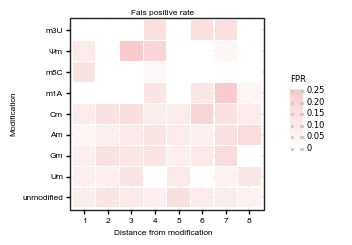

In [20]:
import pandas as pd
data=pd.DataFrame({"Modification":mod_list,"1":distance_1,"2":distance_2,"3":distance_3,"4":distance_4,"5":distance_5,"6":distance_6,"7":distance_7,"8":distance_8})
data=data.round(2)
data['Modification'] = pd.Categorical(data['Modification'], categories=pd.unique(data['Modification']))
melted_data = pd.melt(data, id_vars=['Modification'], var_name='Distance', value_name='FPR')


p=(ggplot(melted_data, aes("Distance","Modification", fill="FPR"))
 + geom_tile(aes(width=.95, height=.95))
 #+ geom_text(aes(label="FPR"), size=6)
 +theme(panel_background=element_rect(fill=gray, alpha=0),
            panel_grid_major=element_line(size=0.3, alpha=0.3,color=black),
            panel_grid_minor=element_line(size=0.3, alpha=0.3,color=black),
            panel_border=element_rect(color=black, size=1),
            axis_text=element_text(size=6,family="Arial",color="black"),
            axis_title_x=element_text(size=6,family="Arial",color="black"),
            axis_title_y=element_text(size=6,family="Arial",color="black"),
            plot_title=element_text(margin={'b': 1, 'r': 0, 'units': 'pt'},size=6,family="Arial",color="black",hjust=0.5),
            #legend_position =  "none",
            figure_size=[2.5,2.5],
            legend_text=element_text(size=6),
            legend_key_size=6,
            legend_title=element_text(size=6)
       )  
  +scale_fill_gradient(low = "#FFFFFF", high = "#F8CCCC")  
  #+scale_y_discrete(labels=["m1A","A"])
  +labs(x="Distance from modification",y="Modification")
  +ggtitle("Fals positive rate ")
)

print(p)
p.save("figure/supplemental_figure_6b_fpr_with_nearby_modifications.pdf")

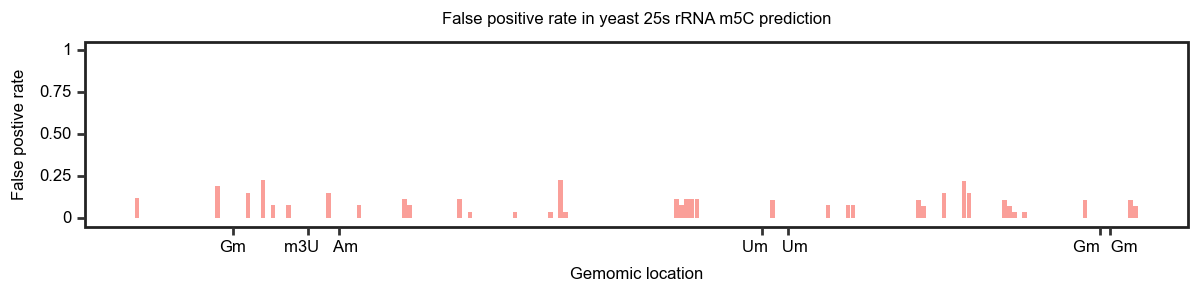

In [163]:
import numpy as np

false_postives=np.array(list(false_positive_dict.values()))[:,2]

data["site"]=site_list
data_plot=pd.DataFrame()
data_plot["false positive rate"]=list(false_postives)
data_plot["site"]=list(false_positive_dict.keys())


custom_breaks = [805, 807,817,867,876,898,2619,2634,2640,2724,2729,2791,2793]
custom_labels = ['Gm', 'Am',"Am","Gm","Am","Um","Gm","m3U   ","   Am","Um   ","   Um","Gm      ","      Gm"]

black = '#222222'
gray = '#666666'
red = '#FF3333'
green = '#66CC00'
blue = '#3333FF'
purple = '#9933FF'
orange = '#FF8000'
yellow = '#FFFF33'
c1="#F8766D"
c2="#00BA38" 
c3="#619CFF"

p1 = (ggplot()
        #+geom_bar(data,aes(x="Probabilities",y = "Proportion"),stat="identity",width=0.6)
        +geom_bar(data_plot,aes(x="site",y="false positive rate"),fill=c1,stat="identity",alpha=0.7)
        +theme(panel_background=element_rect(fill=gray, alpha=0),
            panel_grid_major=element_line(size=0.3, alpha=0,color=black),
            panel_grid_minor=element_line(size=0.3, alpha=0,color=black),
            panel_border=element_rect(color=black, size=1),
            axis_text_x=element_text(size=6,family="Arial",color="black",angle=0),
            axis_text_y=element_text(size=6,family="Arial",color="black"),
            axis_title_x=element_text(size=6,family="Arial",color="black"),
            axis_title_y=element_text(size=6,family="Arial",color="black"),
            plot_title=element_text(margin={'b': 1, 'r': 0, 'units': 'pt'},size=6,family="Arial",color="black",hjust=0.5),
            #axis_text_x=element_text(rotation=45, hjust=0.5),
            figure_size=[6,1.53],
            #legend_title = element_text(size=6), #change legend title font size
            #legend_text = element_text(size=6),
            #legend_background=element_rect(size=0.5,alpha=0),
            legend_position=(0.60,0.4),
            #legend_key_size=4   #change legend text font size
              ) 
      
        +ylim([0,1])
        +labs(x = "Gemomic location", y ="False postive rate")
        #guides(color = guide_legend(title = "Probability cutoff"))
      +ggtitle("False positive rate in yeast 25s rRNA m5C prediction")
        # Define custom breaks and labels
      + scale_x_continuous(breaks=custom_breaks, labels=custom_labels)
      
      +scale_color_manual(c1)
)
print(p1)
p1.save("figure/supplemental_figure_6a_false_positive_rate_with_nearby_modifications_m5C_pos_800-900.pdf")

In [ ]:
# test m6A model in yeast rRNA

In [12]:
import argparse
import traceback

import pandas as pd
import numpy as np
from scipy import interpolate

from sklearn import metrics
from sklearn import datasets
from sklearn.model_selection import train_test_split as ts
from sklearn.metrics import roc_curve,auc,roc_auc_score,precision_recall_curve

import torch
import torch.nn as nn
from torch.utils.data import Dataset
from torch.autograd import Variable

from plotnine import *
import warnings

# Ignore all warnings
warnings.filterwarnings("ignore")


torch.cuda.empty_cache()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("device=",device)

black = '#222222'
gray = '#666666'
red = '#FF3333'
green = '#66CC00'
blue = '#3333FF'
purple = '#9933FF'
orange = '#FF8000'
yellow = '#FFFF33'



class Config:

    train_dir="m5C/feature/train/"
    test_dir="ELIGOS_C/feature/test/"
    #train_dir = "data/motif/CTCAC/train/"
    #test_dir = "data/motif/CTCAC/test/"
    batch_size = 500
    learning_rate=0.00001
    
    
kmer_encode_dic={'A': 0, "C": 1, "G": 2, "T": 3}   

class BahdanauAttention(nn.Module):
    """
    Bahdanau Attention mechanism module.

    Args:
        in_features (int): Number of input features.
        hidden_units (int): Number of hidden units.
        num_task (int): Number of tasks.
    """
    def __init__(self,in_features, hidden_units,num_task):
        super(BahdanauAttention,self).__init__()
        self.W1 = nn.Linear(in_features=in_features,out_features=hidden_units)
        self.W2 = nn.Linear(in_features=in_features,out_features=hidden_units)
        self.V = nn.Linear(in_features=hidden_units, out_features=num_task)

    def forward(self, hidden_states, values):
        hidden_with_time_axis = torch.unsqueeze(hidden_states,dim=1)

        score  = self.V(nn.Tanh()(self.W1(values)+self.W2(hidden_with_time_axis)))
        attention_weights = nn.Softmax(dim=1)(score)
        values = torch.transpose(values,1,2)   # transpose to make it suitable for matrix multiplication
        #print(attention_weights.shape,values.shape)
        context_vector = torch.matmul(values,attention_weights)
        context_vector = torch.transpose(context_vector,1,2)
        return context_vector, attention_weights

class TandemMod(nn.Module):
    def __init__(self,num_classes=2,vocab_zie=5, embedding_size=4,seq_len=5):
        super(TandemMod,self).__init__()

        self.seq_len=seq_len
        self.embed = nn.Embedding(vocab_zie, embedding_size)

        self.cnn_1d = nn.Sequential(
            nn.Conv1d(in_channels=1,out_channels=64,kernel_size=7,stride=2,padding=0),
            nn.ReLU(),
            nn.Dropout(p=0.2),
            nn.Conv1d(in_channels=64,out_channels=128,kernel_size=3,stride=1,padding=0),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2,padding=1),
            nn.Dropout(p=0.2),
            nn.Conv1d(in_channels=128,out_channels=128,kernel_size=3,stride=1,padding=1),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2,padding=1),

        )
        self.lstm=nn.LSTM(input_size=128,hidden_size=128,batch_first=True,bidirectional=True)
        self.attention=BahdanauAttention(in_features=256,hidden_units=10,num_task=1)
        self.fc = nn.Sequential(
            nn.Linear(in_features=1536,out_features=1536),
            nn.ReLU(),
            nn.Linear(in_features=1536, out_features=1024),
            nn.ReLU(),
            nn.Linear(in_features=1024, out_features=512),
            nn.ReLU(),
            nn.Linear(in_features=512, out_features=512),
            nn.ReLU(),
            nn.Linear(in_features=512,out_features=2)
        )

        self.lstm_seq=nn.LSTM(input_size=4+5,hidden_size=128,batch_first=True,bidirectional=True)   #embedding_size+feature_num


    def seq_to_digit(self,seq):
        return torch.Tensor([{'A': 0, "C": 1, "G": 2, "T": 3}[i] for i in list(seq)]).long()


    def forward(self,x,kmer,mean,std,intense,dwell,base_quality):
        kmer_embedded=self.embed(kmer)
        mean = torch.reshape(mean, (-1, self.seq_len, 1)).float()
        std = torch.reshape(std, (-1, self.seq_len, 1)).float()
        intense = torch.reshape(intense, (-1, self.seq_len, 1)).float()
        dwell = torch.reshape(dwell, (-1, self.seq_len, 1)).float()
        base_quality = torch.reshape(base_quality, (-1, self.seq_len, 1)).float()
        
        out_seq=torch.cat((kmer_embedded,mean,std,intense,dwell,base_quality),2)


        out_seq,(h_n_seq,c_n_seq)=self.lstm_seq(out_seq)

        x = self.cnn_1d(x)

        batch_size, features, seq_len = x.size()
        x = x.view(batch_size, seq_len, features)  # parepare input for LSTM

        output, (h_n, c_n) = self.lstm(x)

        h_n = h_n.view(batch_size, output.size()[-1])  # pareprae input for Attention
        context_vector, attention_weights = self.attention(h_n, output)  # Attention (batch_size, num_task, unit)


        out=torch.cat((out_seq[:,0,:],out_seq[:,1,:],out_seq[:,2,:],out_seq[:,3,:],out_seq[:,4,:],context_vector[:,0,:]),1)
        #out=context_vector[:,0,:]
        out.view(out.size()[0],1,out.size()[1])
        x=self.fc(out)
        #x.view(x.size()[0], 1, x.size()[1])
        return x


class NN(TandemMod):
    def __init__(self):
        """
        Initialize the NN class.
        Inherits from the TandemMod class.
        """
        super(NN, self).__init__()





class MyDataset(Dataset):
    """
    Custom dataset class.

    Args:
        x (list or numpy array): Input data.
        y (list or numpy array): Target data.

    """
    def __init__(self,x,y):
        self.x=x
        self.y=y

    def __getitem__(self, index):
        return self.x[index],self.y[index]

    def __len__(self):
        return len(self.x)


def make_weights_for_balanced_classes(images, nclasses):
    """
    Computes weights for balancing classes in a dataset.

    Args:
        images (list): List of images.
        nclasses (int): Number of classes.

    Returns:
        list: List of weights.

    """
    count = [0] * nclasses
    for item in images:
        count[item[1]] += 1
    weight_per_class = [0.] * nclasses
    N = float(sum(count))
    for i in range(nclasses):
        weight_per_class[i] = N/float(count[i])
    weight = [0] * len(images)
    for idx, val in enumerate(images):
        weight[idx] = weight_per_class[val[1]]
    return weight


from torch.utils.data import WeightedRandomSampler
class CustomWeightedRandomSampler(WeightedRandomSampler):
    """
    Custom implementation of WeightedRandomSampler.
    WeightedRandomSampler except allows for more than 2^24 samples to be sampled
    Args:
        *args: Variable length argument list.
        **kwargs: Arbitrary keyword arguments.

    """
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)

    def __iter__(self):
        rand_tensor = np.random.choice(range(0, len(self.weights)),
                                       size=self.num_samples,
                                       p=self.weights.numpy() / torch.sum(self.weights).numpy(),
                                       replace=self.replacement)
        rand_tensor = torch.from_numpy(rand_tensor)
        return iter(rand_tensor.tolist())

print("loading data...")

model = TandemMod(num_classes=2,vocab_zie=5, embedding_size=4,seq_len=5).to(device)
optimizer = torch.optim.Adam(model.parameters(),lr = 0.001)

loss_func = torch.nn.CrossEntropyLoss()#.to(device)
#predict_result=open("rice/results/WT_precit_results.tsv","w")

def predict(model,dataset,cut_off_threshold):
    """
    Predicts the output of the model on the given dataset.

    Parameters:
        model (nn.Module): The trained model to use for prediction.
        dataset (torch.utils.data.Dataset): The dataset to predict on.

    Returns:
        fpr (array): False positive rates.
        tpr (array): True positive rates.
        precision (array): Precision values.
        recall (array): Recall values.
        roc_auc (float): Area under the ROC curve.
        pr_auc (float): Area under the precision-recall curve.
    """

    dataloader=torch.utils.data.DataLoader(dataset=dataset, 
                                           batch_size=30000, 
                                           shuffle=True,
                                           num_workers=36,
                                           pin_memory=True)

    try:

        test_acc = 0.
        y_test = []
        y_pred = []
        label_dict={0:"m5C",1:"C"}

        for i,(batch_x, batch_y) in enumerate(dataloader):

            signal, kmer, mean, std, intense, dwell,base_quality = batch_x
            signal= Variable(signal.to(device)).to(torch.float32)

            kmer = Variable(kmer.to(device)).to(torch.long)
            mean = Variable(mean.to(device)).to(torch.float32)
            std = Variable(std.to(device)).to(torch.float32)
            intense = Variable(intense.to(device)).to(torch.float32)
            dwell = Variable(dwell.to(device)).to(torch.float32)
            base_quality = Variable(base_quality.to(device)).to(torch.float32)
            batch_size, features = signal.size()
            signal = signal.view(batch_size, 1, features)

            out = model(signal, kmer, mean, std, intense, dwell,base_quality )
            batch_size, out_channels = out.size()

            out = out.view(batch_size, out_channels)
            pred = torch.max(out, 1)[1].numpy()

            out=torch.softmax(out,dim=1)
            probabilities=out.detach().numpy()[:,1]
            batch_y=batch_y.detach().numpy()
            #print(probabilities)
            
            
            selected_batch_y=[]
            selected_probabilities=[]
            for j in range(len(batch_y)):
                if probabilities[j]<cut_off_threshold[0] or probabilities[j]>cut_off_threshold[1]:
                    selected_batch_y.append(batch_y[j])
                    selected_probabilities.append(probabilities[j])
            
            print("Probability cutoff:",cut_off_threshold[0],cut_off_threshold[1],"\tPreserved sites:",len(selected_batch_y))
            fpr,tpr,thersholds=roc_curve(selected_batch_y,selected_probabilities)
            precision,recall,thersholds=precision_recall_curve(selected_batch_y,selected_probabilities)
            
            roc_auc=auc(fpr,tpr)
            pr_auc=auc(recall,precision)
            
            return fpr,tpr,precision,recall,roc_auc,pr_auc,len(selected_batch_y)/len(batch_y),probabilities,batch_y
            
    except Exception as e:
        print(e)
        traceback.print_exc()
        
if __name__ == "__main__":
    parser = argparse.ArgumentParser(description='Extract feature from signal.')
    parser.add_argument('-feature', default='BaseCalled_template',help='Basecall subgroup Nanoraw resquiggle into. Default is BaseCalled_template')
    args = parser.parse_args()
  
    
   

device= cpu
loading data...


In [13]:
#get read quality
import numpy as np
read_id_dict={}
read_qualities=[]
length_dict={}
sam_file="/home/wuyou/Projects/paper/yeast.sam"
with open(sam_file) as f:
    for line in f:
        if line[0]=="@":
            continue
            
        read_id=line.split("\t")[0]
        flag=line.split("\t")[1]
        quality_string_list=list(line.split("\t")[10])
        #print(quality_string_list)
        quality_int_list = [ord(char) - 33 for char in quality_string_list]
        
        read_quality=np.mean(quality_int_list)
        if read_quality>18 and len(quality_int_list)>600:
            read_qualities.append(read_quality)
            read_id_dict[read_id]=1
print(len(read_id_dict))

28191


In [14]:
input_feature="/home/wuyou/Projects/paper/yeast_A.feature.tsv"
output_feature="/home/wuyou/Projects/paper/yeast/test"
out=open(output_feature,"w")
with open(input_feature) as f:
    for line in f:
        read_id=line.split("\t")[0]
        contig=line.split("\t")[1]
        site=int(line.split("\t")[2])
        motif=line.split("\t")[3]
        #if contig=="25s" and site>=2600 and site<=2800:
        #if contig=="25s" and site>=0:
        if contig=="25s" and site==816:
            
            #print(motif)
            if read_id_dict.get(read_id,0):
                out.writelines(line)
out.close()  

Probability cutoff: 0.5 0.5 	Preserved sites: 160
     Probabilities  label
0     3.411208e-05      0
1     8.779026e-01      0
2     1.444183e-07      0
3     2.348804e-04      0
4     9.203961e-17      0
..             ...    ...
155   6.243775e-15      0
156   1.000000e+00      0
157   4.588152e-08      0
158   5.006756e-02      0
159   4.908387e-09      0

[160 rows x 2 columns]


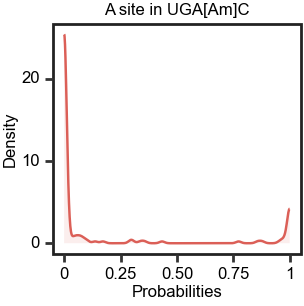

In [16]:
#A
modified_site= [645, 649, 650, 663, 805, 807, 817, 867, 876, 898, 908, 1133, 1142, 1437, 1449, 1450, 1888, 2142, 2197, 2220, 2256, 2278, 2280, 2281, 2288, 2337, 2347, 2395, 2417, 2421, 2619, 2634, 2640, 2724, 2729, 2791, 2793, 2870, 2948, 2959,
               750,772, 953, 1231,1566,1602,1755,
              801,711, 947, 997,1500,1632,1703,
               1780,1951,2010,2240,2455,2669,2811]



x_test_median_mad,y_test_median_mad,site_list=[],[],[]
#f=open("/home/wuyou/Projects/paper/yeast_C.feature.tsv")
f=open("/home/wuyou/Projects/paper/yeast/test")
for i,line in enumerate(f):
    if i>3e4:
        break
    line=line.rstrip()
    items=line.split("\t")
    read_id=line.split("\t")[0]
    site=int(line.split("\t")[2])
    if site in modified_site:
        #pass
        continue
        #pass
    if not read_id_dict.get(read_id,0):
        continue

    signals="|".join(items[9:14]).split("|")
    signal=np.array([float(signal) for signal in signals])
    #signal=(signal-np.mean(signal))/np.std(signal)
    kmer = items[3]
    kmer=np.array([kmer_encode_dic[base] for base in kmer])
    mean = np.array([float(item) for item in items[4].split("|")])
    std = np.array([float(item) for item in items[5].split("|")])
    intense = np.array([float(item) for item in items[6].split("|")])
    dwell = np.array([float(item) for item in items[7].split("|")])/200
    base_quality = np.array([float(item) for item in items[8].split("|")])/40
    x=[signal, kmer, mean, std, intense, dwell,base_quality]
    x_test_median_mad.append(x)
    y_test_median_mad.append(0)
    site_list.append(site)
f.close()

dataset=MyDataset(x_test_median_mad,y_test_median_mad)


#model= torch.load('/home/wuyou/Projects/paper/model/m6A_Os_AD_median_mad_length_1000.pkl')
model = torch.load("/home/wuyou/Projects/paper/model/m6A_Os_AD_median_mad.pkl")

fpr,tpr,precision,recall,roc_auc_MMAD,pr_auc_MMAD,preserved_ratio,probabilities,labels=predict(model,dataset,[0.5,0.5])

data=pd.DataFrame(dict(Probabilities=probabilities,label=labels)) 

data_C=data[data["label"]==0]
print(data)
#data.to_csv("data/density_of_reads_probablilities_m5C_on_ELIGOS.csv")
p1 = (ggplot()
        #+geom_bar(data,aes(x="Probabilities",y = "Proportion"),stat="identity",width=0.6)
        +geom_density(data_C,aes(x="Probabilities",fill="black",color="black"),alpha=0.1,show_legend=False)
        +theme(panel_background=element_rect(fill=gray, alpha=0),
            panel_grid_major=element_line(size=0.3, alpha=0,color=black),
            panel_grid_minor=element_line(size=0.3, alpha=0,color=black),
            panel_border=element_rect(color=black, size=1),
            axis_text=element_text(size=6,family="Arial",color="black"),
            axis_title_x=element_text(size=6,family="Arial",color="black"),
            axis_title_y=element_text(size=6,family="Arial",color="black"),
            plot_title=element_text(margin={'b': 1, 'r': 0, 'units': 'pt'},size=6,family="Arial",color="black",hjust=0.5),
            #axis_text_x=element_text(rotation=45, hjust=0.5),
            figure_size=[1.52,1.53],
            #legend_title = element_text(size=6), #change legend title font size
            #legend_text = element_text(size=6),
            #legend_background=element_rect(size=0.5,alpha=0),
            legend_position=(0.60,0.4),
            #legend_key_size=4   #change legend text font size
              ) 
       +xlim([0,1])
        +labs(x = "Probabilities", y ="Density")
        #guides(color = guide_legend(title = "Probability cutoff"))
      +ggtitle("A site in UGA[Am]C")

)
print(p1)
p1.save("figure/supplemental_figure_6l_yeast_25s_rRNA_A_probability_site816_TGAAC.pdf")


In [17]:
input_feature="/home/wuyou/Projects/paper/yeast_A.feature.tsv"
output_feature="/home/wuyou/Projects/paper/yeast/test"
out=open(output_feature,"w")
with open(input_feature) as f:
    for line in f:
        read_id=line.split("\t")[0]
        contig=line.split("\t")[1]
        site=int(line.split("\t")[2])
        motif=line.split("\t")[3]
        #if contig=="25s" and site>=2600 and site<=2800:
        #if contig=="25s" and site>=0:
        if contig=="25s" and site==896:
            
            #print(motif)
            if read_id_dict.get(read_id,0):
                out.writelines(line)
out.close()  

Probability cutoff: 0.5 0.5 	Preserved sites: 175
     Probabilities  label
0     4.739377e-20      0
1     6.231365e-19      0
2     9.936914e-01      0
3     3.329750e-13      0
4     1.190246e-07      0
..             ...    ...
170   4.809793e-11      0
171   2.201439e-09      0
172   3.848185e-10      0
173   3.034499e-15      0
174   2.647569e-05      0

[175 rows x 2 columns]


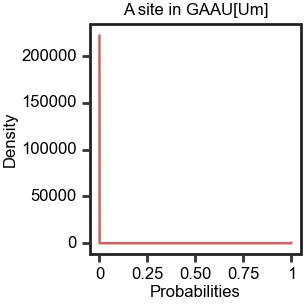

In [82]:
#
modified_site= [645, 649, 650, 663, 805, 807, 817, 867, 876, 898, 908, 1133, 1142, 1437, 1449, 1450, 1888, 2142, 2197, 2220, 2256, 2278, 2280, 2281, 2288, 2337, 2347, 2395, 2417, 2421, 2619, 2634, 2640, 2724, 2729, 2791, 2793, 2870, 2948, 2959,
               750,772, 953, 1231,1566,1602,1755,
              801,711, 947, 997,1500,1632,1703,
               1780,1951,2010,2240,2455,2669,2811]



x_test_median_mad,y_test_median_mad,site_list=[],[],[]
#f=open("/home/wuyou/Projects/paper/yeast_C.feature.tsv")
f=open("/home/wuyou/Projects/paper/yeast/test")
for i,line in enumerate(f):
    if i>3e4:
        break
    line=line.rstrip()
    items=line.split("\t")
    read_id=line.split("\t")[0]
    site=int(line.split("\t")[2])
    if site in modified_site:
        #pass
        continue
        #pass
    if not read_id_dict.get(read_id,0):
        continue

    signals="|".join(items[9:14]).split("|")
    signal=np.array([float(signal) for signal in signals])
    #signal=(signal-np.mean(signal))/np.std(signal)
    kmer = items[3]
    kmer=np.array([kmer_encode_dic[base] for base in kmer])
    mean = np.array([float(item) for item in items[4].split("|")])
    std = np.array([float(item) for item in items[5].split("|")])
    intense = np.array([float(item) for item in items[6].split("|")])
    dwell = np.array([float(item) for item in items[7].split("|")])/200
    base_quality = np.array([float(item) for item in items[8].split("|")])/40
    x=[signal, kmer, mean, std, intense, dwell,base_quality]
    x_test_median_mad.append(x)
    y_test_median_mad.append(0)
    site_list.append(site)
f.close()

dataset=MyDataset(x_test_median_mad,y_test_median_mad)


#model= torch.load('/home/wuyou/Projects/paper/model/m6A_Os_AD_median_mad_length_1000.pkl')
model = torch.load("/home/wuyou/Projects/paper/model/m6A_Os_AD_median_mad.pkl")

fpr,tpr,precision,recall,roc_auc_MMAD,pr_auc_MMAD,preserved_ratio,probabilities,labels=predict(model,dataset,[0.5,0.5])

data=pd.DataFrame(dict(Probabilities=probabilities,label=labels)) 

data_C=data[data["label"]==0]
print(data)
#data.to_csv("data/density_of_reads_probablilities_m5C_on_ELIGOS.csv")
p1 = (ggplot()
        #+geom_bar(data,aes(x="Probabilities",y = "Proportion"),stat="identity",width=0.6)
        +geom_density(data_C,aes(x="Probabilities",fill="black",color="black"),alpha=0.1,show_legend=False)
        +theme(panel_background=element_rect(fill=gray, alpha=0),
            panel_grid_major=element_line(size=0.3, alpha=0,color=black),
            panel_grid_minor=element_line(size=0.3, alpha=0,color=black),
            panel_border=element_rect(color=black, size=1),
            axis_text=element_text(size=6,family="Arial",color="black"),
            axis_title_x=element_text(size=6,family="Arial",color="black"),
            axis_title_y=element_text(size=6,family="Arial",color="black"),
            plot_title=element_text(margin={'b': 1, 'r': 0, 'units': 'pt'},size=6,family="Arial",color="black",hjust=0.5),
            #axis_text_x=element_text(rotation=45, hjust=0.5),
            figure_size=[1.52,1.53],
            #legend_title = element_text(size=6), #change legend title font size
            #legend_text = element_text(size=6),
            #legend_background=element_rect(size=0.5,alpha=0),
            legend_position=(0.60,0.4),
            #legend_key_size=4   #change legend text font size
              ) 
       +xlim([0,1])
        +labs(x = "Probabilities", y ="Density")
        #guides(color = guide_legend(title = "Probability cutoff"))
      +ggtitle("A site in GAAU[Um]")

)
print(p1)
p1.save("figure/yeast_25s_rRNA_A_probability_site896_GAAUU.pdf")


In [18]:
input_feature="/home/wuyou/Projects/paper/yeast_A.feature.tsv"
output_feature="/home/wuyou/Projects/paper/yeast/test"
out=open(output_feature,"w")
with open(input_feature) as f:
    for line in f:
        read_id=line.split("\t")[0]
        contig=line.split("\t")[1]
        site=int(line.split("\t")[2])
        motif=line.split("\t")[3]
        #if contig=="25s" and site>=2600 and site<=2800:
        #if contig=="25s" and site>=0:
        if contig=="25s" and site==1143:
            
            #print(motif)
            if read_id_dict.get(read_id,0):
                out.writelines(line)
out.close()  

Probability cutoff: 0.5 0.5 	Preserved sites: 208
     Probabilities  label
0     1.531171e-05      0
1     2.705027e-01      0
2     5.060319e-05      0
3     8.621292e-01      0
4     3.592605e-03      0
..             ...    ...
203   6.072494e-01      0
204   4.152417e-05      0
205   3.184263e-03      0
206   3.672322e-07      0
207   3.693864e-01      0

[208 rows x 2 columns]


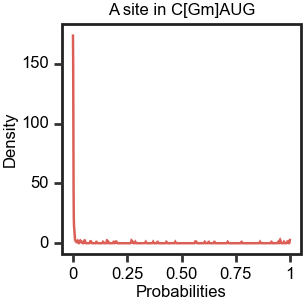

In [20]:
#
modified_site= [645, 649, 650, 663, 805, 807, 817, 867, 876, 898, 908, 1133, 1142, 1437, 1449, 1450, 1888, 2142, 2197, 2220, 2256, 2278, 2280, 2281, 2288, 2337, 2347, 2395, 2417, 2421, 2619, 2634, 2640, 2724, 2729, 2791, 2793, 2870, 2948, 2959,
               750,772, 953, 1231,1566,1602,1755,
              801,711, 947, 997,1500,1632,1703,
               1780,1951,2010,2240,2455,2669,2811]



x_test_median_mad,y_test_median_mad,site_list=[],[],[]
#f=open("/home/wuyou/Projects/paper/yeast_C.feature.tsv")
f=open("/home/wuyou/Projects/paper/yeast/test")
for i,line in enumerate(f):
    if i>3e4:
        break
    line=line.rstrip()
    items=line.split("\t")
    read_id=line.split("\t")[0]
    site=int(line.split("\t")[2])
    if site in modified_site:
        #pass
        continue
        #pass
    if not read_id_dict.get(read_id,0):
        continue

    signals="|".join(items[9:14]).split("|")
    signal=np.array([float(signal) for signal in signals])
    #signal=(signal-np.mean(signal))/np.std(signal)
    kmer = items[3]
    kmer=np.array([kmer_encode_dic[base] for base in kmer])
    mean = np.array([float(item) for item in items[4].split("|")])
    std = np.array([float(item) for item in items[5].split("|")])
    intense = np.array([float(item) for item in items[6].split("|")])
    dwell = np.array([float(item) for item in items[7].split("|")])/200
    base_quality = np.array([float(item) for item in items[8].split("|")])/40
    x=[signal, kmer, mean, std, intense, dwell,base_quality]
    x_test_median_mad.append(x)
    y_test_median_mad.append(0)
    site_list.append(site)
f.close()

dataset=MyDataset(x_test_median_mad,y_test_median_mad)


#model= torch.load('/home/wuyou/Projects/paper/model/m6A_Os_AD_median_mad_length_1000.pkl')
model = torch.load("/home/wuyou/Projects/paper/model/m6A_Os_AD_median_mad.pkl")

fpr,tpr,precision,recall,roc_auc_MMAD,pr_auc_MMAD,preserved_ratio,probabilities,labels=predict(model,dataset,[0.5,0.5])

data=pd.DataFrame(dict(Probabilities=probabilities,label=labels)) 

data_C=data[data["label"]==0]
print(data)
#data.to_csv("data/density_of_reads_probablilities_m5C_on_ELIGOS.csv")
p1 = (ggplot()
        #+geom_bar(data,aes(x="Probabilities",y = "Proportion"),stat="identity",width=0.6)
        +geom_density(data_C,aes(x="Probabilities",fill="black",color="black"),alpha=0.1,show_legend=False)
        +theme(panel_background=element_rect(fill=gray, alpha=0),
            panel_grid_major=element_line(size=0.3, alpha=0,color=black),
            panel_grid_minor=element_line(size=0.3, alpha=0,color=black),
            panel_border=element_rect(color=black, size=1),
            axis_text=element_text(size=6,family="Arial",color="black"),
            axis_title_x=element_text(size=6,family="Arial",color="black"),
            axis_title_y=element_text(size=6,family="Arial",color="black"),
            plot_title=element_text(margin={'b': 1, 'r': 0, 'units': 'pt'},size=6,family="Arial",color="black",hjust=0.5),
            #axis_text_x=element_text(rotation=45, hjust=0.5),
            figure_size=[1.52,1.53],
            #legend_title = element_text(size=6), #change legend title font size
            #legend_text = element_text(size=6),
            #legend_background=element_rect(size=0.5,alpha=0),
            legend_position=(0.60,0.4),
            #legend_key_size=4   #change legend text font size
              ) 
       +xlim([0,1])
        +labs(x = "Probabilities", y ="Density")
        #guides(color = guide_legend(title = "Probability cutoff"))
      +ggtitle("A site in C[Gm]AUG")

)
print(p1)
p1.save("figure/supplemental_figure_6k_yeast_25s_rRNA_A_probability_site1143_CGATG.pdf")


In [21]:
input_feature="/home/wuyou/Projects/paper/yeast_A.feature.tsv"
output_feature="/home/wuyou/Projects/paper/yeast/test"
out=open(output_feature,"w")
with open(input_feature) as f:
    for line in f:
        read_id=line.split("\t")[0]
        contig=line.split("\t")[1]
        site=int(line.split("\t")[2])
        motif=line.split("\t")[3]
        #if contig=="25s" and site>=2600 and site<=2800:
        #if contig=="25s" and site>=0:
        if contig=="25s" and site==2636:
            
            #print(motif)
            if read_id_dict.get(read_id,0):
                out.writelines(line)
out.close()  

Probability cutoff: 0.5 0.5 	Preserved sites: 309
     Probabilities  label
0     9.993219e-11      0
1     9.626356e-01      0
2     1.509066e-09      0
3     1.672014e-14      0
4     3.005195e-04      0
..             ...    ...
304   4.814345e-11      0
305   2.019464e-07      0
306   1.313097e-04      0
307   4.288245e-06      0
308   3.420823e-08      0

[309 rows x 2 columns]


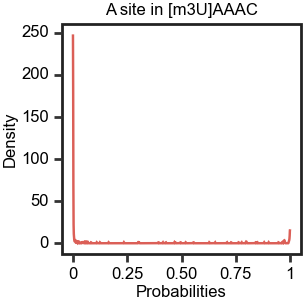

In [22]:
#
modified_site= [645, 649, 650, 663, 805, 807, 817, 867, 876, 898, 908, 1133, 1142, 1437, 1449, 1450, 1888, 2142, 2197, 2220, 2256, 2278, 2280, 2281, 2288, 2337, 2347, 2395, 2417, 2421, 2619, 2634, 2640, 2724, 2729, 2791, 2793, 2870, 2948, 2959,
               750,772, 953, 1231,1566,1602,1755,
              801,711, 947, 997,1500,1632,1703,
               1780,1951,2010,2240,2455,2669,2811]



x_test_median_mad,y_test_median_mad,site_list=[],[],[]
#f=open("/home/wuyou/Projects/paper/yeast_C.feature.tsv")
f=open("/home/wuyou/Projects/paper/yeast/test")
for i,line in enumerate(f):
    if i>3e4:
        break
    line=line.rstrip()
    items=line.split("\t")
    read_id=line.split("\t")[0]
    site=int(line.split("\t")[2])
    if site in modified_site:
        #pass
        continue
        #pass
    if not read_id_dict.get(read_id,0):
        continue

    signals="|".join(items[9:14]).split("|")
    signal=np.array([float(signal) for signal in signals])
    #signal=(signal-np.mean(signal))/np.std(signal)
    kmer = items[3]
    kmer=np.array([kmer_encode_dic[base] for base in kmer])
    mean = np.array([float(item) for item in items[4].split("|")])
    std = np.array([float(item) for item in items[5].split("|")])
    intense = np.array([float(item) for item in items[6].split("|")])
    dwell = np.array([float(item) for item in items[7].split("|")])/200
    base_quality = np.array([float(item) for item in items[8].split("|")])/40
    x=[signal, kmer, mean, std, intense, dwell,base_quality]
    x_test_median_mad.append(x)
    y_test_median_mad.append(0)
    site_list.append(site)
f.close()

dataset=MyDataset(x_test_median_mad,y_test_median_mad)


#model= torch.load('/home/wuyou/Projects/paper/model/m6A_Os_AD_median_mad_length_1000.pkl')
model = torch.load("/home/wuyou/Projects/paper/model/m6A_Os_AD_median_mad.pkl")

fpr,tpr,precision,recall,roc_auc_MMAD,pr_auc_MMAD,preserved_ratio,probabilities,labels=predict(model,dataset,[0.5,0.5])

data=pd.DataFrame(dict(Probabilities=probabilities,label=labels)) 

data_C=data[data["label"]==0]
print(data)
#data.to_csv("data/density_of_reads_probablilities_m5C_on_ELIGOS.csv")
p1 = (ggplot()
        #+geom_bar(data,aes(x="Probabilities",y = "Proportion"),stat="identity",width=0.6)
        +geom_density(data_C,aes(x="Probabilities",fill="black",color="black"),alpha=0.1,show_legend=False)
        +theme(panel_background=element_rect(fill=gray, alpha=0),
            panel_grid_major=element_line(size=0.3, alpha=0,color=black),
            panel_grid_minor=element_line(size=0.3, alpha=0,color=black),
            panel_border=element_rect(color=black, size=1),
            axis_text=element_text(size=6,family="Arial",color="black"),
            axis_title_x=element_text(size=6,family="Arial",color="black"),
            axis_title_y=element_text(size=6,family="Arial",color="black"),
            plot_title=element_text(margin={'b': 1, 'r': 0, 'units': 'pt'},size=6,family="Arial",color="black",hjust=0.5),
            #axis_text_x=element_text(rotation=45, hjust=0.5),
            figure_size=[1.52,1.53],
            #legend_title = element_text(size=6), #change legend title font size
            #legend_text = element_text(size=6),
            #legend_background=element_rect(size=0.5,alpha=0),
            legend_position=(0.60,0.4),
            #legend_key_size=4   #change legend text font size
              ) 
       +xlim([0,1])
        +labs(x = "Probabilities", y ="Density")
        #guides(color = guide_legend(title = "Probability cutoff"))
      +ggtitle("A site in [m3U]AAAC")

)
print(p1)
p1.save("figure/supplemental_figure_6j_yeast_25s_rRNA_A_probability_site2636_UAAAC.pdf")


In [1]:
#overall false positive
input_feature="/home/wuyou/Projects/paper/yeast_A.feature.tsv"
output_feature="/home/wuyou/Projects/paper/yeast/test"
out=open(output_feature,"w")
with open(input_feature) as f:
    for line in f:
        read_id=line.split("\t")[0]
        contig=line.split("\t")[1]
        site=int(line.split("\t")[2])
        motif=line.split("\t")[3]
        #if contig=="25s" and site>=2600 and site<=2800:
        #if contig=="25s" and site>=0:
        if contig=="25s" and 1:
            
            #print(motif)
            if read_id_dict.get(read_id,0):
                out.writelines(line)
out.close()  

NameError: name 'read_id_dict' is not defined

Probability cutoff: 0.5 0.5 	Preserved sites: 29280
       Probabilities  label
0       1.942284e-14      0
1       6.835751e-03      0
2       1.556940e-02      0
3       1.348488e-16      0
4       1.183813e-13      0
...              ...    ...
29275   3.684158e-01      0
29276   9.993985e-01      0
29277   2.036699e-05      0
29278   4.846045e-06      0
29279   5.806595e-04      0

[29280 rows x 2 columns]


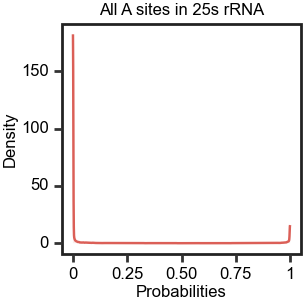

In [24]:
#
modified_site= [645, 649, 650, 663, 805, 807, 817, 867, 876, 898, 908, 1133, 1142, 1437, 1449, 1450, 1888, 2142, 2197, 2220, 2256, 2278, 2280, 2281, 2288, 2337, 2347, 2395, 2417, 2421, 2619, 2634, 2640, 2724, 2729, 2791, 2793, 2870, 2948, 2959,
               750,772, 953, 1231,1566,1602,1755,
              801,711, 947, 997,1500,1632,1703,
               1780,1951,2010,2240,2455,2669,2811]


site_list=[]
x_test_median_mad,y_test_median_mad,site_list=[],[],[]
#f=open("/home/wuyou/Projects/paper/yeast_C.feature.tsv")
f=open("/home/wuyou/Projects/paper/yeast/test")
for i,line in enumerate(f):
    if i>3e4:
        break
    line=line.rstrip()
    items=line.split("\t")
    read_id=line.split("\t")[0]
    site=int(line.split("\t")[2])
    if site in modified_site:
        #pass
        continue
        #pass
    if not read_id_dict.get(read_id,0):
        continue

    signals="|".join(items[9:14]).split("|")
    signal=np.array([float(signal) for signal in signals])
    #signal=(signal-np.mean(signal))/np.std(signal)
    kmer = items[3]
    kmer=np.array([kmer_encode_dic[base] for base in kmer])
    mean = np.array([float(item) for item in items[4].split("|")])
    std = np.array([float(item) for item in items[5].split("|")])
    intense = np.array([float(item) for item in items[6].split("|")])
    dwell = np.array([float(item) for item in items[7].split("|")])/200
    base_quality = np.array([float(item) for item in items[8].split("|")])/40
    x=[signal, kmer, mean, std, intense, dwell,base_quality]
    x_test_median_mad.append(x)
    y_test_median_mad.append(0)
    site_list.append(site)
f.close()

dataset=MyDataset(x_test_median_mad,y_test_median_mad)


#model= torch.load('/home/wuyou/Projects/paper/model/m6A_Os_AD_median_mad_length_1000.pkl')
model = torch.load("/home/wuyou/Projects/paper/model/m6A_Os_AD_median_mad.pkl")

fpr,tpr,precision,recall,roc_auc_MMAD,pr_auc_MMAD,preserved_ratio,probabilities,labels=predict(model,dataset,[0.5,0.5])

data=pd.DataFrame(dict(Probabilities=probabilities,label=labels)) 

data_C=data[data["label"]==0]
print(data)
#data.to_csv("data/density_of_reads_probablilities_m5C_on_ELIGOS.csv")
p1 = (ggplot()
        #+geom_bar(data,aes(x="Probabilities",y = "Proportion"),stat="identity",width=0.6)
        +geom_density(data_C,aes(x="Probabilities",fill="black",color="black"),alpha=0.1,show_legend=False)
        +theme(panel_background=element_rect(fill=gray, alpha=0),
            panel_grid_major=element_line(size=0.3, alpha=0,color=black),
            panel_grid_minor=element_line(size=0.3, alpha=0,color=black),
            panel_border=element_rect(color=black, size=1),
            axis_text=element_text(size=6,family="Arial",color="black"),
            axis_title_x=element_text(size=6,family="Arial",color="black"),
            axis_title_y=element_text(size=6,family="Arial",color="black"),
            plot_title=element_text(margin={'b': 1, 'r': 0, 'units': 'pt'},size=6,family="Arial",color="black",hjust=0.5),
            #axis_text_x=element_text(rotation=45, hjust=0.5),
            figure_size=[1.52,1.53],
            #legend_title = element_text(size=6), #change legend title font size
            #legend_text = element_text(size=6),
            #legend_background=element_rect(size=0.5,alpha=0),
            legend_position=(0.60,0.4),
            #legend_key_size=4   #change legend text font size
              ) 
       +xlim([0,1])
        +labs(x = "Probabilities", y ="Density")
        #guides(color = guide_legend(title = "Probability cutoff"))
      +ggtitle("All A sites in 25s rRNA")

)
print(p1)
p1.save("figure/supplemental_figure_6i_yeast_25s_rRNA_A_probability_all.pdf")


In [25]:
false_positive_dict={}
data["site"]=site_list
for i,site in enumerate(data["site"]):
    if site not in false_positive_dict:
        false_positive_dict[site]=[0,0,0]
    p=data["Probabilities"][i]
    if p>0.5:
        false_positive_dict[site][0]+=1
    false_positive_dict[site][1]+=1
for i,site in enumerate(data["site"]):
    false_positive_dict[site][2]=false_positive_dict[site][0]/false_positive_dict[site][1]

In [26]:
false_positive_dict

mod_type=['m1A', 'Am', 'Cm', 'Cm', 'Gm', 'Am', 'Am', 'Gm', 'Am', 'Um', 'Gm', 'Am', 'Gm', 'Cm', 'Am', 'Gm', 'Um', 'm1A', 'Cm', 'Am', 'Am', 'm5C', 'Am', 'Am', 'Gm', 'Cm', 'Ψm', 'Gm', 'Um', 'Um', 'Gm', 'm3U', 'Am', 'Um', 'Um', 'Gm', 'Gm', 'Gm', 'm3U', 'm5C', 'Um', 'Gm', 'Am', 'Cm', 'Cm',
         "unmodified","unmodified","unmodified","unmodified","unmodified","unmodified","unmodified",
         "unmodified","unmodified","unmodified","unmodified","unmodified","unmodified","unmodified",
         "unmodified","unmodified","unmodified","unmodified","unmodified","unmodified","unmodified"]

#fpr_with_distance
#modified_site
modified_site_dict={site:mod for site,mod in zip(modified_site,mod_type)}

def get_nearest_mod_type(site):
    distance_list=[]
    for i in modified_site_dict:
        distance_list.append(abs(site-i))

    min_distance_index=distance_list.index(min(distance_list))
    min_distance=min(distance_list)
    mod=mod_type[min_distance_index]
    return mod,min_distance

modified_type_dict={}
for site in false_positive_dict:
    mod,min_distance=get_nearest_mod_type(site)
    fpr=false_positive_dict[site][2]
    
    if mod not in modified_type_dict:
        modified_type_dict[mod]={}
    
    if min_distance not in modified_type_dict[mod]:
        modified_type_dict[mod][min_distance]=[]

    modified_type_dict[mod][min_distance].append(fpr)


modified_type_dict

mod_list,distance_1,distance_2,distance_3,distance_4,distance_5,distance_6,distance_7,distance_8=[],[],[],[],[],[],[],[],[]
import numpy as np

for mod in modified_type_dict:
    mod_list.append(mod)

    distance_1.append(np.mean(modified_type_dict[mod].get(1,[0])))
    distance_2.append(np.mean(modified_type_dict[mod].get(2,[0])))
    distance_3.append(np.mean(modified_type_dict[mod].get(3,[0])))
    distance_4.append(np.mean(modified_type_dict[mod].get(4,[0])))
    distance_5.append(np.mean(modified_type_dict[mod].get(5,[0])))
    distance_6.append(np.mean(modified_type_dict[mod].get(6,[0])))
    distance_7.append(np.mean(modified_type_dict[mod].get(7,[0])))
    distance_8.append(np.mean(modified_type_dict[mod].get(8,[0])))

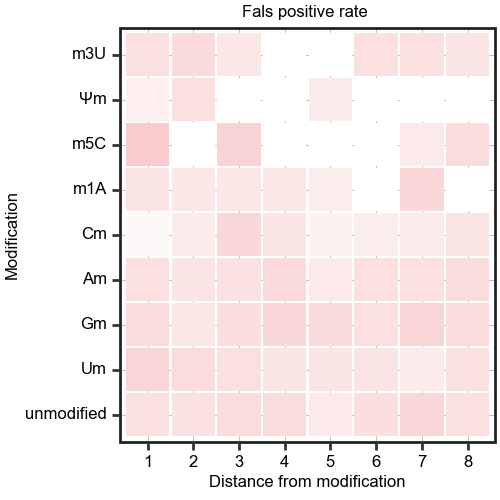

In [27]:
import pandas as pd
data=pd.DataFrame({"Modification":mod_list,"1":distance_1,"2":distance_2,"3":distance_3,"4":distance_4,"5":distance_5,"6":distance_6,"7":distance_7,"8":distance_8})
data=data.round(2)
data['Modification'] = pd.Categorical(data['Modification'], categories=pd.unique(data['Modification']))
melted_data = pd.melt(data, id_vars=['Modification'], var_name='Distance', value_name='FPR')


p=(ggplot(melted_data, aes("Distance","Modification", fill="FPR"))
 + geom_tile(aes(width=.95, height=.95))
 #+ geom_text(aes(label="FPR"), size=6)
 +theme(panel_background=element_rect(fill=gray, alpha=0),
            panel_grid_major=element_line(size=0.3, alpha=0.3,color=black),
            panel_grid_minor=element_line(size=0.3, alpha=0.3,color=black),
            panel_border=element_rect(color=black, size=1),
            axis_text=element_text(size=6,family="Arial",color="black"),
            axis_title_x=element_text(size=6,family="Arial",color="black"),
            axis_title_y=element_text(size=6,family="Arial",color="black"),
            plot_title=element_text(margin={'b': 1, 'r': 0, 'units': 'pt'},size=6,family="Arial",color="black",hjust=0.5),
            legend_position =  "none",figure_size=[2.5,2.5])  
  +scale_fill_gradient(low = "#FFFFFF", high = "#F8CCCC")  
  #+scale_y_discrete(labels=["m1A","A"])
  +labs(x="Distance from modification",y="Modification")
  +ggtitle("Fals positive rate ")
)

print(p)
p.save("figure/supplemental_figure_6h_fpr_with_nearby_modifications_m6A.pdf")

In [28]:
#overall false positive
input_feature="/home/wuyou/Projects/paper/yeast_A.feature.tsv"
output_feature="/home/wuyou/Projects/paper/yeast/test"
out=open(output_feature,"w")
with open(input_feature) as f:
    for line in f:
        read_id=line.split("\t")[0]
        contig=line.split("\t")[1]
        site=int(line.split("\t")[2])
        motif=line.split("\t")[3]
        if contig=="25s" and site>=2600 and site<=2800:
        #if contig=="25s" and site>=0:
        #if contig=="25s" and 1:
            
            #print(motif)
            if read_id_dict.get(read_id,0):
                out.writelines(line)
out.close()  

In [29]:
#
modified_site= [645, 649, 650, 663, 805, 807, 817, 867, 876, 898, 908, 1133, 1142, 1437, 1449, 1450, 1888, 2142, 2197, 2220, 2256, 2278, 2280, 2281, 2288, 2337, 2347, 2395, 2417, 2421, 2619, 2634, 2640, 2724, 2729, 2791, 2793, 2870, 2948, 2959,
               750,772, 953, 1231,1566,1602,1755,
              801,711, 947, 997,1500,1632,1703,
               1780,1951,2010,2240,2455,2669,2811]


site_list=[]
x_test_median_mad,y_test_median_mad,site_list=[],[],[]
#f=open("/home/wuyou/Projects/paper/yeast_C.feature.tsv")
f=open("/home/wuyou/Projects/paper/yeast/test")
for i,line in enumerate(f):
    if i>3e4:
        break
    line=line.rstrip()
    items=line.split("\t")
    read_id=line.split("\t")[0]
    site=int(line.split("\t")[2])
    if site in modified_site:
        #pass
        continue
        #pass
    if not read_id_dict.get(read_id,0):
        continue

    signals="|".join(items[9:14]).split("|")
    signal=np.array([float(signal) for signal in signals])
    #signal=(signal-np.mean(signal))/np.std(signal)
    kmer = items[3]
    kmer=np.array([kmer_encode_dic[base] for base in kmer])
    mean = np.array([float(item) for item in items[4].split("|")])
    std = np.array([float(item) for item in items[5].split("|")])
    intense = np.array([float(item) for item in items[6].split("|")])
    dwell = np.array([float(item) for item in items[7].split("|")])/200
    base_quality = np.array([float(item) for item in items[8].split("|")])/40
    x=[signal, kmer, mean, std, intense, dwell,base_quality]
    x_test_median_mad.append(x)
    y_test_median_mad.append(0)
    site_list.append(site)
f.close()

dataset=MyDataset(x_test_median_mad,y_test_median_mad)


#model= torch.load('/home/wuyou/Projects/paper/model/m6A_Os_AD_median_mad_length_1000.pkl')
model = torch.load("/home/wuyou/Projects/paper/model/m6A_Os_AD_median_mad.pkl")

fpr,tpr,precision,recall,roc_auc_MMAD,pr_auc_MMAD,preserved_ratio,probabilities,labels=predict(model,dataset,[0.5,0.5])

data=pd.DataFrame(dict(Probabilities=probabilities,label=labels)) 

data_C=data[data["label"]==0]



Probability cutoff: 0.5 0.5 	Preserved sites: 17675


In [30]:
false_positive_dict={}
data["site"]=site_list
for i,site in enumerate(data["site"]):
    if site not in false_positive_dict:
        false_positive_dict[site]=[0,0,0]
    p=data["Probabilities"][i]
    if p>0.5:
        false_positive_dict[site][0]+=1
    false_positive_dict[site][1]+=1
for i,site in enumerate(data["site"]):
    false_positive_dict[site][2]=false_positive_dict[site][0]/false_positive_dict[site][1]

In [31]:
false_positive_dict

mod_type=['m1A', 'Am', 'Cm', 'Cm', 'Gm', 'Am', 'Am', 'Gm', 'Am', 'Um', 'Gm', 'Am', 'Gm', 'Cm', 'Am', 'Gm', 'Um', 'm1A', 'Cm', 'Am', 'Am', 'm5C', 'Am', 'Am', 'Gm', 'Cm', 'Ψm', 'Gm', 'Um', 'Um', 'Gm', 'm3U', 'Am', 'Um', 'Um', 'Gm', 'Gm', 'Gm', 'm3U', 'm5C', 'Um', 'Gm', 'Am', 'Cm', 'Cm',
         "unmodified","unmodified","unmodified","unmodified","unmodified","unmodified","unmodified",
         "unmodified","unmodified","unmodified","unmodified","unmodified","unmodified","unmodified",
         "unmodified","unmodified","unmodified","unmodified","unmodified","unmodified","unmodified"]

#fpr_with_distance
#modified_site
modified_site_dict={site:mod for site,mod in zip(modified_site,mod_type)}

def get_nearest_mod_type(site):
    distance_list=[]
    for i in modified_site_dict:
        distance_list.append(abs(site-i))

    min_distance_index=distance_list.index(min(distance_list))
    min_distance=min(distance_list)
    mod=mod_type[min_distance_index]
    return mod,min_distance

modified_type_dict={}
for site in false_positive_dict:
    mod,min_distance=get_nearest_mod_type(site)
    fpr=false_positive_dict[site][2]
    
    if mod not in modified_type_dict:
        modified_type_dict[mod]={}
    
    if min_distance not in modified_type_dict[mod]:
        modified_type_dict[mod][min_distance]=[]

    modified_type_dict[mod][min_distance].append(fpr)


modified_type_dict

mod_list,distance_1,distance_2,distance_3,distance_4,distance_5,distance_6,distance_7,distance_8=[],[],[],[],[],[],[],[],[]
import numpy as np

for mod in modified_type_dict:
    mod_list.append(mod)

    distance_1.append(np.mean(modified_type_dict[mod].get(1,[0])))
    distance_2.append(np.mean(modified_type_dict[mod].get(2,[0])))
    distance_3.append(np.mean(modified_type_dict[mod].get(3,[0])))
    distance_4.append(np.mean(modified_type_dict[mod].get(4,[0])))
    distance_5.append(np.mean(modified_type_dict[mod].get(5,[0])))
    distance_6.append(np.mean(modified_type_dict[mod].get(6,[0])))
    distance_7.append(np.mean(modified_type_dict[mod].get(7,[0])))
    distance_8.append(np.mean(modified_type_dict[mod].get(8,[0])))

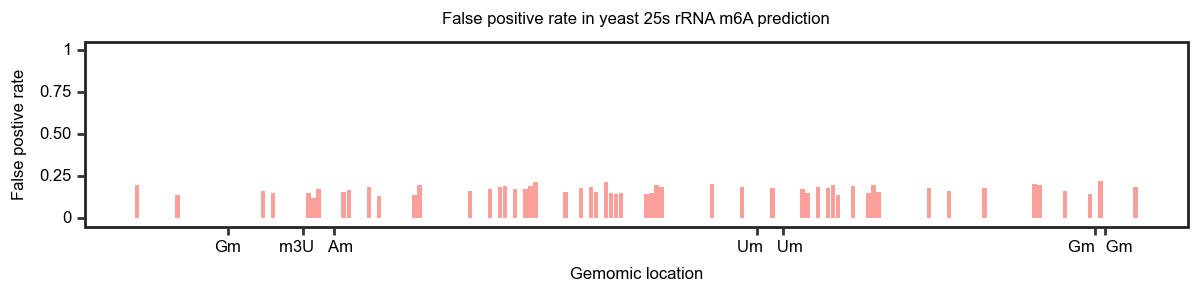

In [32]:
import numpy as np

false_postives=np.array(list(false_positive_dict.values()))[:,2]

data["site"]=site_list
data_plot=pd.DataFrame()
data_plot["false positive rate"]=list(false_postives)
data_plot["site"]=list(false_positive_dict.keys())


custom_breaks = [805, 807,817,867,876,898,2619,2634,2640,2724,2729,2791,2793]
custom_labels = ['Gm', 'Am',"Am","Gm","Am","Um","Gm","m3U   ","   Am","Um   ","   Um","Gm      ","      Gm"]

black = '#222222'
gray = '#666666'
red = '#FF3333'
green = '#66CC00'
blue = '#3333FF'
purple = '#9933FF'
orange = '#FF8000'
yellow = '#FFFF33'
c1="#F8766D"
c2="#00BA38" 
c3="#619CFF"

p1 = (ggplot()
        #+geom_bar(data,aes(x="Probabilities",y = "Proportion"),stat="identity",width=0.6)
        +geom_bar(data_plot,aes(x="site",y="false positive rate"),fill=c1,stat="identity",alpha=0.7)
        +theme(panel_background=element_rect(fill=gray, alpha=0),
            panel_grid_major=element_line(size=0.3, alpha=0,color=black),
            panel_grid_minor=element_line(size=0.3, alpha=0,color=black),
            panel_border=element_rect(color=black, size=1),
            axis_text_x=element_text(size=6,family="Arial",color="black",angle=0),
            axis_text_y=element_text(size=6,family="Arial",color="black"),
            axis_title_x=element_text(size=6,family="Arial",color="black"),
            axis_title_y=element_text(size=6,family="Arial",color="black"),
            plot_title=element_text(margin={'b': 1, 'r': 0, 'units': 'pt'},size=6,family="Arial",color="black",hjust=0.5),
            #axis_text_x=element_text(rotation=45, hjust=0.5),
            figure_size=[6,1.53],
            #legend_title = element_text(size=6), #change legend title font size
            #legend_text = element_text(size=6),
            #legend_background=element_rect(size=0.5,alpha=0),
            legend_position=(0.60,0.4),
            #legend_key_size=4   #change legend text font size
              ) 
      
        +ylim([0,1])
        +labs(x = "Gemomic location", y ="False postive rate")
        #guides(color = guide_legend(title = "Probability cutoff"))
      +ggtitle("False positive rate in yeast 25s rRNA m6A prediction")
        # Define custom breaks and labels
      + scale_x_continuous(breaks=custom_breaks, labels=custom_labels)
      
      +scale_color_manual(c1)
)
print(p1)
p1.save("figure/supplemental_figure_6g_false_positive_rate_with_nearby_modifications_m6A_pos_800-900.pdf")